<a href="https://colab.research.google.com/github/PavankumarUppar/SMA/blob/main/SMAProgram3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install Node2Vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.6 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1


Computing transition probabilities:   0%|          | 0/6 [00:00<?, ?it/s]

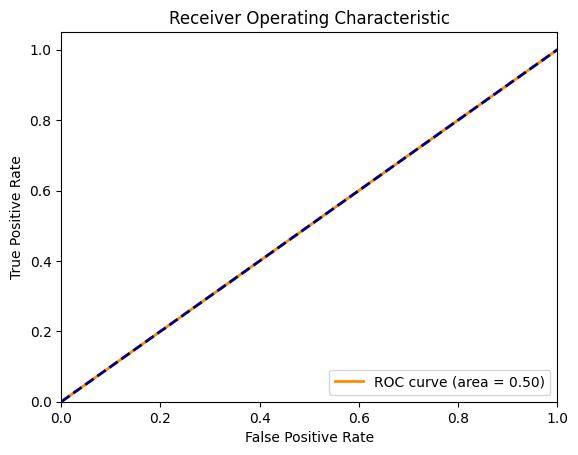

ROC AUC: 0.5


In [ ]:
import networkx as nx
from node2vec import Node2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Create a sample graph
graph = nx.Graph()
graph.add_edges_from([(1, 2), (1, 3), (1, 4), (2, 4), (2, 5), (3, 4), (4, 5), (4, 6)])

# Preprocess the graph
largest_component = max(nx.connected_components(graph), key=len)
graph = graph.subgraph(largest_component)

# Generate node embeddings using Node2Vec
node2vec = Node2Vec(graph, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
node_embeddings = model.wv

# Prepare the training data for link prediction
train_edges = list(graph.edges())
train_labels = [1] * len(train_edges)
train_neg_samples = list(nx.non_edges(graph))[:len(train_edges)]
train_labels += [0] * len(train_neg_samples)

# Create feature vectors for training data
train_edge_features = [node_embeddings[str(u)] + node_embeddings[str(v)] for u, v in train_edges]
train_neg_features = [node_embeddings[str(u)] + node_embeddings[str(v)] for u, v in train_neg_samples]
train_features = train_edge_features + train_neg_features

# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(train_features, train_labels)

# Prepare the test data for link prediction
test_labels = [1] * len(train_edges) + [0] * len(train_edges)

# Create feature vectors for test data
test_edge_features = [node_embeddings[str(u)] + node_embeddings[str(v)] for u, v in train_edges]
test_neg_features = [node_embeddings[str(u)] + node_embeddings[str(v)] for u, v in train_edges]
test_features = test_edge_features + test_neg_features

# Use the trained classifier to predict link probabilities
link_probabilities = classifier.predict_proba(test_features)[:, 1]

# Compute ROC curve and ROC AUC
fpr, tpr, _ = roc_curve(test_labels, link_probabilities)
roc_auc = roc_auc_score(test_labels, link_probabilities)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print("ROC AUC:", roc_auc)
